# Visual Question Answering model Demo and Tutorial
This is an jupyter notebook with explanation and tutorial on Visual Question Answering. This model retuens good results without using any attention models, memory networks (other than LSTM) and fine-tuning, which are essential recipe for current best results.

I have tried to explain different parts, and their choices. This is meant to be an interactive tutorial, feel free to change the model parameters and experiment. 

All the files required to run this ipython notebook can be obtained from


In [1]:
! git clone https://github.com/singhbhupender1/VQA-proj.git

Cloning into 'VQA-proj'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 48 (delta 6), reused 38 (delta 0), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [0]:
# we require python 3 for this

In [2]:
# uncomment this part if tensorflow version is < 1.2 or more than 1.4
 ! pip uninstall tensorflow
 ! pip install tensorflow==1.4

Uninstalling tensorflow-1.13.1:
  Would remove:
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.13.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.13.1
    100% |████████████████████████████████| 41.2MB 551kB/s 
    100% |████████████████████████████████| 1.7MB 15.1MB/s 
    100% |████████████████████████████████| 890kB 15.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
stable-baselines 2.2.1 has requirement tensorflow>=1.5.0, but you'll have tensorflow 1.4.0 which is incompatible.
magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.4.0 which is incompatible.


In [3]:
# uncomment this commands if keras version is lower than 2.0 or more than 2.0
!pip uninstall keras
!pip install keras==2.0.8

Uninstalling Keras-2.2.4:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.2.4.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.2.4
    100% |████████████████████████████████| 276kB 12.4MB/s 
textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.


In [4]:
# install spacy
! python -m spacy download en_vectors_web_lg

    100% |████████████████████████████████| 661.8MB 76.2MB/s 
  Running setup.py install for en-vectors-web-lg ... done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_vectors_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_vectors_web_lg

    You can now load the model via spacy.load('en_vectors_web_lg')



In [5]:
# uncomment this if your scikit learn version is above 0.20 or above
!pip uninstall scikit-learn
!pip install scikit-learn==0.19

Uninstalling scikit-learn-0.20.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/scikit_learn-0.20.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-0.20.3
    100% |████████████████████████████████| 12.4MB 4.6MB/s 
yellowbrick 0.9.1 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.0 which is incompatible.
textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
librosa 0.6.3 has requirement scikit-learn!=0.19.0,>=0.14.0, but you'll have scikit-learn 0.19.0 which is incompatible.
imbalanced-learn 0.4.3 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.0 which is incompatible.
fancyimpute 0.4.3 has requirement scikit-learn>=0.19.1, but you'll have scikit-learn 0.19.0 which is incompatible.


In [7]:
# check version of tensorflow and keras
import tensorflow as tf
import keras as k
print(tf.__version__)
print(k.__version__)


1.4.0
2.0.8


In [13]:
# used for copying weights file when running on google colab
# not really necessary
import shutil
shutil.copy('/content/vgg16_weights.h5', '/content/VQA-proj/models/CNN/vgg16_weights.h5')

'/content/VQA-proj/models/CNN/vgg16_weights.h5'

In [0]:
# for switching to repo folder in colab
import os
os.chdir('/content/VQA-proj')

## Load the libraries

In [0]:
# doing the necessary imports 
%matplotlib inline
import os, argparse
import cv2, spacy, numpy as np
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.externals import joblib
from keras.layers import merge
# to supress warnings
import warnings
warnings.filterwarnings('ignore')

# please load the pretrained VGG16 weights file from the link below and put it in the CNN folder

<https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view?usp=sharing>


## Load the models and weights files
This does not load the models yet, but we are providing the files


In [0]:
# to designate necessary folders for files
VQA_model_file_name      = 'models/VQA/VQA_MODEL.json'
VQA_weights_file_name   = 'models/VQA/VQA_MODEL_WEIGHTS.hdf5'
label_encoder_file_name  = 'models/VQA/FULL_labelencoder_trainval_new.pkl'
CNN_weights_file_name   = 'models/CNN/vgg16_weights.h5'

## Model Idea
This uses a classical CNN-LSTM  model like shown below, where Image features and language features are computed separately and combined together and a multi-layer perceptron is trained on the combined features.

Similar models have been presented at following links, this work takes ideas from them.

1. <https://github.com/abhshkdz/neural-vqa>
2. <https://github.com/avisingh599/visual-qa>
3. https://github.com/VT-vision-lab/VQA_LSTM_CNN

<img src="images/vqa_model_schema.png">

## Pretrained VGG Net (VGG-16)

While VGG Net is not the best CNN model for image features, GoogLeNet (winner 2014) and ResNet (winner 2015) have superior classification scores, but VGG Net is very versatile, simple, relatively small and more importantly portable to use. 

For reference here is the VGG 16 performance on ILSVRC-2012
<img src="http://www.robots.ox.ac.uk/~vgg/research/very_deep/images/table_ILSVRC.png">

## Compile the model

In [0]:
def get_image_model(CNN_weights_file_name):
    ''' Takes the CNN weights file, and returns the VGG model update 
    with the weights. Requires the file VGG.py inside models/CNN '''
    from models.CNN.VGG import VGG_16
    image_model = VGG_16(CNN_weights_file_name)

     # this is standard VGG 16 without the last two layers
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model

## Plot the Model

Keras has a function which allows you to visualize the model in block diagram. Let's do it !

In [0]:
model_vgg = get_image_model(CNN_weights_file_name)

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model_vgg, to_file='images/model_vgg.png')

<img src="images/model_vgg.png">

## Extract Image features


Extracting image features involves, taking a raw image, and running it through the model, until we reach the last layer. In this case our model is not 100% same as VGG Net, because we are not going to use the last two layer of the VGG. It is because the last layer of VGG Net is a 1000 way softmax and the second last layer is the Dropout.

Thus we are extracting the 4096 Dimension image features from VGG-16


In [0]:
def get_image_features(image_file_name, CNN_weights_file_name):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    image_features = np.zeros((1, 4096))
    # Magic_Number = 4096  > VGG modelin son katmanından gelir.

     # Since VGG was trained as a image of 224x224, every new image
    # is required to go through the same transformation
    
    im = cv2.resize(cv2.imread(image_file_name), (224, 224))
    im = im.transpose((2,0,1)) # görüntüyü RGBA'a dönüştürür.

    
    # this axis dimension is required because VGG was trained on a dimension
    # of 1, 3, 224, 224 (first axis is for the batch size
    # even though we are using only one image, we have to keep the dimensions consistent
    im = np.expand_dims(im, axis=0) 
    print(im.shape)

    image_features[0,:] = get_image_model(CNN_weights_file_name).predict(im)[0]
    return image_features

# Word Embeddings

The question has to be converted into some form of word embeddings. Most popular is Word2Vec whereas these days state of the art uses [skip-thought vectors](https://github.com/ryankiros/skip-thoughts) or [positional encodings](https://en.wikipedia.org/wiki/Encoding_(memory).

We will use Word2Vec from Stanford called [Glove](http://nlp.stanford.edu/projects/glove/). Glove reduces a given token into a 300 dimensional representation.

In [0]:
def get_question_features(question):
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    word_embeddings = spacy.load('en_vectors_web_lg')
    tokens = word_embeddings(question)
    question_tensor = np.zeros((1, 30, 300))
    for j in range(len(tokens)):
            question_tensor[0,j,:] = tokens[j].vector
    return question_tensor

## Try the embeddings
​
Let's see the embeddings, and their usage with sample words like this -
1. Obama 
2. Putin
3. Banana
4. Monkey

In [0]:
word_embeddings = spacy.load('en', vectors='en_glove_cc_300_1m_vectors')

In [0]:
obama = word_embeddings(u"obama")
putin = word_embeddings(u"putin")
banana = word_embeddings(u"banana")
monkey = word_embeddings(u"monkey")

In [20]:
obama.similarity(putin)

0.5735777213479505

In [23]:
obama.similarity(banana)

0.4924444357063912

In [24]:
banana.similarity(monkey)

0.5471796768752016

As we can see, obama and putin are very similar in representation than obama and banana. This shows you there is some semantic knowledge of the tokens embedded in the 300 dimensional representation. We can do cool arithmatics with these word2vec like 'Queen' - 'King' + 'Boy' = 'Girl'. See [this blog post](http://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/) for more details.

## VQA Model

VQA is a simple model which combines features from Image and Word Embeddings and runs a multiple layer perceptron.

In [0]:
def get_VQA_model(VQA_model_file_name, VQA_weights_file_name):
    ''' Given the VQA model and its weights, compiles and returns the model '''

    # thanks the keras function for loading a model from JSON, this becomes
    # very easy to understand and work. Alternative would be to load model
    # from binary like cPickle but then model would be obfuscated to users
    vqa_model = model_from_json(open(VQA_model_file_name).read())
    vqa_model.load_weights(VQA_weights_file_name)
    vqa_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return vqa_model

In [0]:
import pydot

from keras.utils.vis_utils import plot_model
model_vqa = get_VQA_model(VQA_model_file_name, VQA_weights_file_name)

plot_model(model_vqa, to_file='images/model_vqa.png')

<img src="images/model_vqa.png">

## Lets ask some questions !
​
Let's give a test image and a question

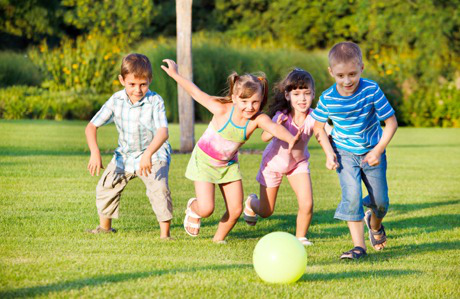

In [22]:
image_file_name = 'images/test/test2.jpeg'
question = u"How is the weather?"
from PIL  import Image
im = Image.open(image_file_name)
im

<center> How is the weather? </center>

In [23]:
## get the image features
image_features = get_image_features(image_file_name, CNN_weights_file_name)

(1, 3, 224, 224)


In [0]:
## get the question features
question_features = get_question_features(question)

In [25]:
y_output = model_vqa.predict([question_features, image_features])
# This task here is represented as a classification into a 1000 top answers
# this means some of the answers were not part of training and thus would 
# not show up in the result.
# These 1000 answers are stored in the sklearn Encoder class
labelencoder = joblib.load(label_encoder_file_name)

for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform(label)))

NameError: ignored

#  Demo to read from the url

# instead of Cv2 we will use io

In [0]:
def get_image_features(image_file_name, CNN_weights_file_name):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    image_features = np.zeros((1, 4096))
        
    from skimage import io
     # if you would rather not install skimage, then use cv2.VideoCapture which surprisingly can read from url
    # see this SO answer http://answers.opencv.org/question/16385/cv2imread-a-url/?answer=16389#post-id-16389
    im = cv2.resize(io.imread(image_file_name), (224, 224))
    im = im.transpose((2,0,1)) 
    # this axis dimension is required because VGG was trained on a dimension
    # of 1, 3, 224, 224 (first axis is for the batch size
    # even though we are using only one image, we have to keep the dimensions consistent
    im = np.expand_dims(im, axis=0) 

    image_features[0,:] = get_image_model(CNN_weights_file_name).predict(im)[0]
    return image_features

In [32]:
image_file_name = "https://d3jkudlc7u70kh.cloudfront.net/bird-fact.jpg"
# get the image features
image_features = get_image_features(image_file_name, CNN_weights_file_name)
image_features.shape

(1, 4096)

<img src="https://d3jkudlc7u70kh.cloudfront.net/bird-fact.jpg">
<center> Which animals are there? </center>

In [0]:
question = u"Which animals are there?"

question_features = get_question_features(question)

In [34]:
y_output = model_vqa.predict([question_features, image_features])

labelencoder = joblib.load(label_encoder_file_name)

for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform(label)))

ValueError: ignored

In [0]:
question = u"Which color is the first bird?"

question_features = get_question_features(question)

<img src="https://d3jkudlc7u70kh.cloudfront.net/bird-fact.jpg">
<center> Which color is the first bird? </center>

In [0]:
y_output = model_vqa.predict([question_features, image_features])

labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):

    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform(label)))

91.51 % blue!
3.59 % white!
1.01 % green!
0.89 % black!
0.8 % blue and white!


#  One more time

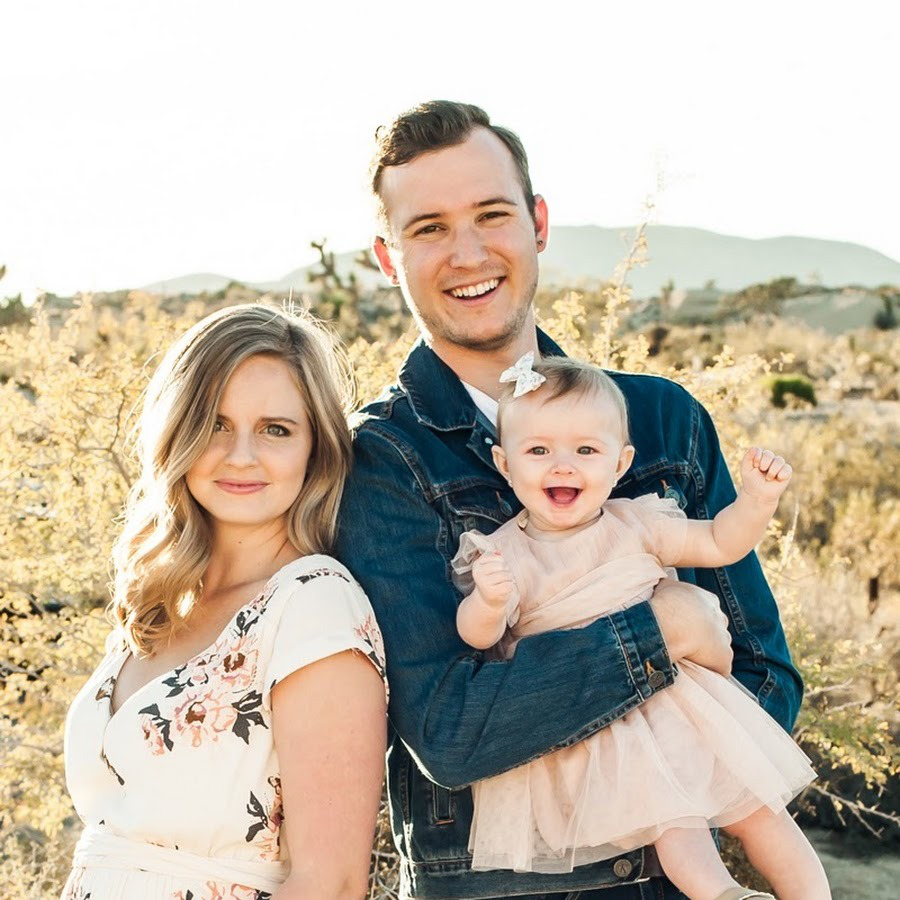

In [0]:
image_file_name = 'images/test/test2.jpg'
question = u"Is there baby?"

from PIL  import Image
im = Image.open(image_file_name)
im

In [0]:
image_features = get_image_features(image_file_name, CNN_weights_file_name)
image_features.shape

(1, 4096)

In [0]:
question_features = get_question_features(question)
question_features.shape

(1, 30, 300)

In [0]:
y_output = model_vqa.predict([question_features, image_features])

labelencoder = joblib.load(label_encoder_file_name)

for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform(label)))

90.58 % yes!
9.41 % no!
0.0 % boy!
0.0 % christmas!
0.0 % girl!


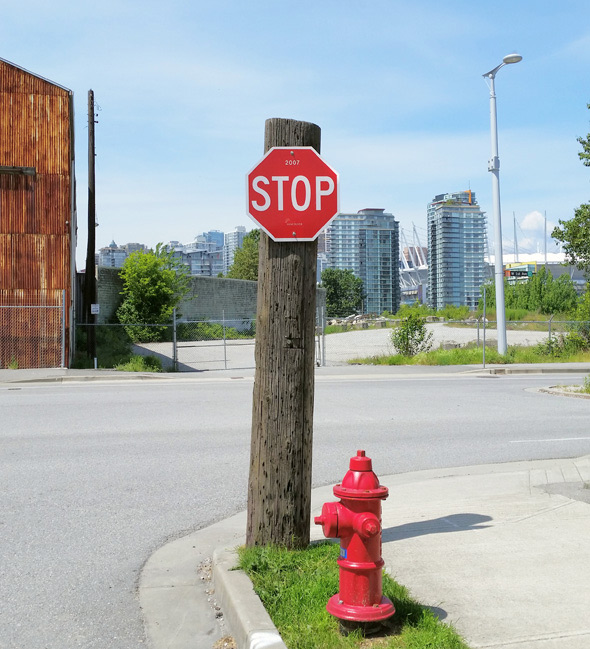

In [0]:
image_file_name = 'images/test/test6.jpg'
question = u"What does the sign say?"

from PIL  import Image
im = Image.open(image_file_name)
im

In [0]:
image_features = get_image_features(image_file_name, CNN_weights_file_name)
question_features = get_question_features(question)

y_output = model_vqa.predict([question_features, image_features])

labelencoder = joblib.load(label_encoder_file_name)

for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform(label)))

28.61 % stop!
27.55 % parking!
9.57 % no parking!
5.14 % stop sign!
4.66 % one way!


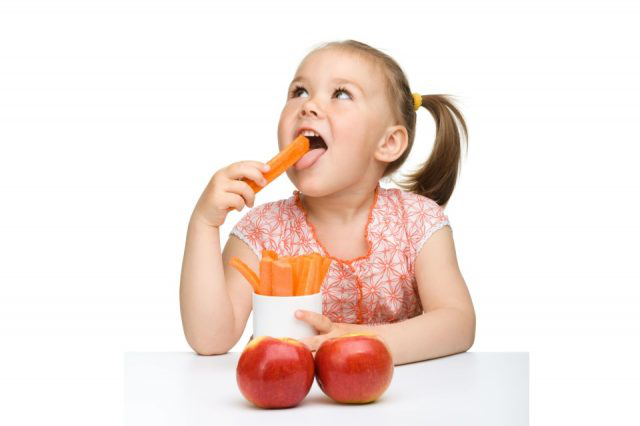

In [0]:
image_file_name = 'images/test/test3.jpg'
question = u"Is she eating apple?"

from PIL  import Image
im = Image.open(image_file_name)
im

In [0]:
image_features = get_image_features(image_file_name, CNN_weights_file_name)
question_features = get_question_features(question)

y_output = model_vqa.predict([question_features, image_features])

labelencoder = joblib.load(label_encoder_file_name)

for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform(label)))

63.06 % no!
36.94 % yes!
0.0 % toy!
0.0 % rainbow!
0.0 % parasailing!


In [0]:
image_file_name = "http://www.newarkhistory.com/indparksoccerkids.jpg"
# get the image features
image_features = get_image_features(image_file_name, CNN_weights_file_name)
image_features.shape

In [0]:
question = u"What are they playing?"

question_features = get_question_features(question)

In [0]:
y_output = model_vqa.predict([question_features, image_features])

labelencoder = joblib.load(label_encoder_file_name)

for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform(label)))

## Result
Copying the result to validate your output.

**55.44 %  frisbee<br/>
18.91 %  tennis<br/>
16.95 %  baseball<br/>
08.31 %  soccer<br/>
00.07 %  ball <br/>
**


As you can see, it got this wrong, but you can see why it could be harder to guess soccer and easier to guess frisbee, lack of soccer ball and lines at the edge.

Let's ask another question for the same image.

<img src="http://www.newarkhistory.com/indparksoccerkids.jpg">
# <center> Are they playing Frisbee? </center>

question = u"Are they playing Frisbee?"

question_features = get_question_features(question)

In [0]:
y_output = model_vqa.predict([question_features, image_features])

labelencoder = joblib.load(label_encoder_file_name)

for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform(label)))

As you can see, similar information about a Yes/No question elicits different response. This is an impertinent problem with `classification` tasks.
​
Feel free to experiment with different types of questions, `count`, `color`, `location`.
​
More interesting results are obtained when one takes a different crop of a image, instead of just scaling it to 224x224. This is again because we extract only the top level features of CNN model which was trained to classify one object in the image.

# if you want to train the model 

1.first you have to download the data. for this first go into the data dir and run( caution the data set runs 20 GB upwards so will take a considerable amounto 0f time

The script below will download and split the data into training and testing sets

In [0]:
! python vqa_preprocessing.py --download True --split 1

In [0]:
# after downloding the MScoco data . we need to run processing script on data

In [0]:
! python prepro.py --input_train_json data/vqa_raw_train.json --input_test_json data/vqa_raw_test.json --num_ans 1000

In [0]:
# after that you can run command (it requires pytorch) but you can download  pretrained files from the link provided to save time 

In [0]:
! th prepro_img.lua

In [0]:
# next run 

In [0]:
! python train -model DeeperLSTM